# Embedding multiple networks

Often, we are interested in more than one network. Sometimes this arises from thinking
about multiple "layers," where each layer represents a different kind of relationship.

```{figure} ./images/stacked-adj.png
Example of a multiple-layered network (multigraph) from the *Drosophila* larva brain 
connectome.
```

Or, we may have networks which arise from the same process, but at different timepoints. 

Regardless of the data, it is common to want to:
- Generate a single embedding which summarizes the property of each node, regardless
of which network it came from, or
- Compare the role of each node across networks, or
- Quantitatively compare the networks themselves

Each of these tasks (and many others) can benefit from doing network embeddings which
somehow deal with multiple networks. We'll discuss a few approaches and considerations
below, mainly for the spectral methods.


## Do a couple of spectral embeddings

Let's say we have two networks. We wish to come up with an embedding for *each node
in each network*. Since we've already learned about techniques for network embedding, 
why not just apply these techniques separately to each network, and compare the results?

In [6]:
import networkx as nx
import pandas as pd 
from pathlib import Path

DATA_PATH = Path("networks-course/data")

def load_matched(side="left"):
    side = side.lower()
    dir = DATA_PATH / "processed_maggot"
    g = nx.read_edgelist(
        dir / f"matched_{side}_edgelist.csv",
        create_using=nx.DiGraph,
        delimiter=",",
        nodetype=int,
    )
    nodes = pd.read_csv(dir / f"matched_{side}_nodes.csv", index_col=0)
    adj = nx.to_numpy_array(g, nodelist=nodes.index)
    return adj, nodes

left_adj, left_nodes = load_matched('left')
right_adj, right_nodes = load_matched('right')


In [7]:
from graspologic.embed import AdjacencySpectralEmbed

ase = AdjacencySpectralEmbed(n_components=4)
X_left, Y_left = ase.fit_transform(left_adj)
X_right, Y_right = ase.fit_transform(right_adj)

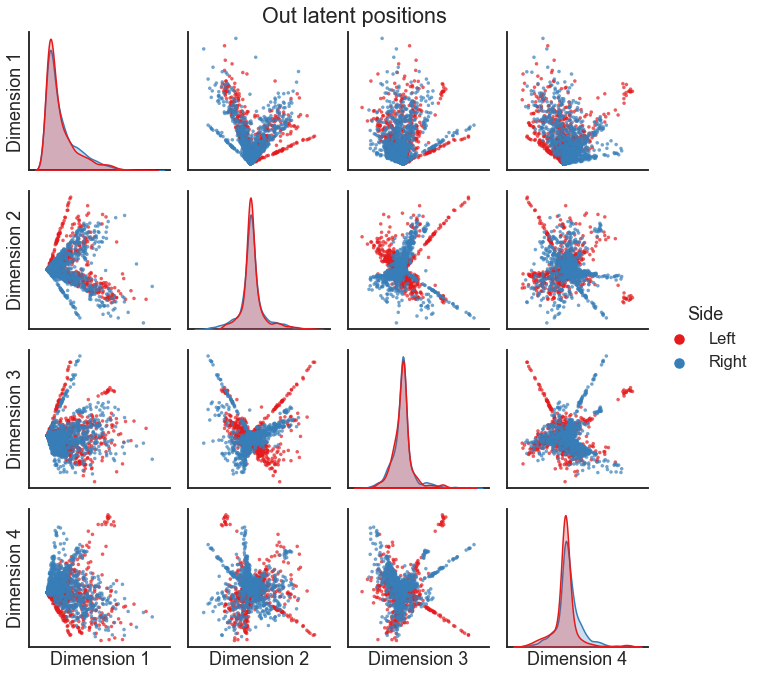

In [10]:
import numpy as np
from graspologic.plot import pairplot

X_both = np.concatenate((X_left, X_right), axis=0)
labels = np.array(len(X_left)*['Left'] + len(X_right)*['Right'])

pairplot(X_both, labels, legend_name='Side', title='Out latent positions')

```{admonition} Question
:class: tip

Based on this plot, would you say that these networks are similar? Why or why not?

Do you notice anything about the relationship of one embedding with regard to the 
other? 
```

## Orthogonal nonidentifiability

Earlier in the course, we discussed a model with a nonidentifiability in its parameters.
As a reminder, this just means that we have some flexibility in the parameters we use
which gives us the same model behavior. Can this arise for the RDPG model, which is the
motivation behind doing ASE? Let's have a look. 

Remember that for the RDPG, we are using the model of $A$ being sampled from a
probability matrix, $P$. $P$ has the structure

$$P = XX^T$$

for an undirected network, or for a directed network, 

$$P = XY^T$$

How can a nonidentifiability pop up here? Note that an [**orthogonal matrix**](https://en.wikipedia.org/wiki/Orthogonal_matrix) $W$ is one 
such that

$$W W^T = W^T W = I$$

Intuitively, these orthogonal matrices represent *rotations* and *reflections* in our 
$d$-dimensional space. They are often called **isometric** transformations of the space,
because they *preserve all interpoint distances*.

```{admonition} Question
:class: tip

Can you think of another set of latent positions, say $Z$, such that or probability
matrix $P = XX^T = ZZ^T$, but $Z \neq X$? 

Hint: where can you insert some orthogonal matrices into the formula $P = XX^T$ such 
that the matrix $P$ is unchanged?
```

